In [1]:
"""
Test MASWavesPy inversion module

This example covers the use of InvertDC objects to:
- Initialize an inversion object. 
- Initialize the inversion routine. The inversion is conducted using 
  Monte Carlo sampling as described in Olafsdottir et al. (2020) with 
  the Fast delta matrix algorithm used for forward modelling (i.e., 
  computation of theoretical dispersion curves).
- Pickle the inversion object (save the inversion results to disk).
- Post-processing of the inversion results:
  - View all shear wave velocity profiles whose associated dispersion curves
    fall within the boundaries of the experimental data at all frequencies.
  - Compute the median (or mean) shear wave velocity profile and the
    associated theoretical dispersion curve.
  - Identify the 10 lowest-misfit shear wave velocity profiles whose associated
    dispersion curves fall within the boundaries of the experimental data.
  - Compute the time-averaged shear wave velocity down to a depth z. 

Input files (prepared):
- Data/Oysand_dc.txt (Experimental dispersion curve with upper/lower boundary curves)
- Data/Oysand_initial.csv (Initial values for soil model parameters for use in inversion)

Outputs:
- inv_TestSite: Initialized inversion object (type inversion.InvertDC).
- Plot showing the initial shear wave velocity (Vs) profile and comparing the 
  corresponding theoretical dispersion curve (DC) to the experimental data.
- Set of sampled Vs profiles and corresponding theoretical DCs, saved to the InvertDC object inv_TestSite.
- Plot showing sampled Vs profiles and corresponding theoretical DCs. 
- InvertDC object inv_TestSite saved to disk using Python's Pickle module.
- Plot showing accepted Vs profiles and corresponding theoretical DCs. 
- TestSite_median_profile: Median and percentile values of the accepted Vs profiles (type dict).
- Plot showing the median and percentile Vs values and comparing the theoretical DC of 
  the median profile to the experimental data.
- lowest_misfit_profiles: Set of 'no_profiles' lowest-misfit Vs profiles retrieved 
  in the inversion (type dict).
- Plot showing the set of lowest-misfit Vs profiles and comparing the corresponding 
  theoretical DCs to the experimental data.
- Time-averaged Vs (Vsz) values computed for z=5 m, z=10 m, z=20 m and z=30 m.
  - Vsz_median: Vsz computed from the median of the accepted Vs profile (type tuple).
  - Vsz_lowest_misfit: Vsz computed from the lowest-misfit Vs profile (type tuple).
  
References
----------
Fast delta matrix algorithm
 - Buchen, P.W. & Ben-Hador, R. (1996). Free-mode surface-wave computations. 
   Geophysical Journal International, 124(3), 869–887. 
   https://doi.org/10.1111/j.1365-246X.1996.tb05642.x 
Inversion scheme 
 - Olafsdottir, E.A., Erlingsson, S. & Bessason, B. (2020). Open-Source 
   MASW Inversion Tool Aimed at Shear Wave Velocity Profiling for Soil Site 
   Explorations. Geosciences, 10(8), 322. https://doi.org/10.3390/geosciences10080322
    
"""


"\nTest MASWavesPy inversion module\n\nThis example covers the use of InvertDC objects to:\n- Initialize an inversion object. \n- Initialize the inversion routine. The inversion is conducted using \n  Monte Carlo sampling as described in Olafsdottir et al. (2020) with \n  the Fast delta matrix algorithm used for forward modelling (i.e., \n  computation of theoretical dispersion curves).\n- Pickle the inversion object (save the inversion results to disk).\n- Post-processing of the inversion results:\n  - View all shear wave velocity profiles whose associated dispersion curves\n    fall within the boundaries of the experimental data at all frequencies.\n  - Compute the median (or mean) shear wave velocity profile and the\n    associated theoretical dispersion curve.\n  - Identify the 10 lowest-misfit shear wave velocity profiles whose associated\n    dispersion curves fall within the boundaries of the experimental data.\n  - Compute the time-averaged shear wave velocity down to a depth z

In [2]:
import maswavespy as sw
from maswavespy import inversion

import pandas as pd
import numpy as np

In [3]:
# Path to sample data
# Experimental dispersion curve (stored as a .txt file in the folder Data)
filename_dc = '/Users/tourei@mines.edu/coding/sits/cryoseismic_imaging/maswavespy/data/AK_dc_some_picks.txt' 
# Initial values for soil model parameters (stored as a .csv file in the folder Data)
filename_initial = '/Users/tourei@mines.edu/coding/sits/cryoseismic_imaging/maswavespy/data/AK_initial.csv' 


In [4]:
# Import experimental dispersion curves
wavelengths = []
c_mean = []; c_low = []; c_up = []
with open(filename_dc, 'r') as file_dc:
    next(file_dc) # Skip the header
    for value in file_dc.readlines():
        wavelengths.append(float(value.split()[0]))
        c_mean.append(float(value.split()[1]))
        c_low.append(float(value.split()[2]))
        c_up.append(float(value.split()[3]))
wavelengths = np.array(wavelengths, dtype='float64')
c_mean = np.array(c_mean, dtype='float64'); 
c_low = np.array(c_low, dtype='float64')
c_up = np.array(c_up, dtype='float64')
    
# Import initial soil model parameters
initial_parameters = pd.read_csv(filename_initial)
h = np.array(initial_parameters['h [m]'].values[0:-1], dtype='float64')
n = int(len(h))
Vs = np.array(initial_parameters['Vs [m/s]'].values, dtype='float64')
rho = np.array(initial_parameters['rho [kg/m3]'].values, dtype='float64')
Vp = []
n_unsat = 0; nu = None
for item in range(len(initial_parameters['saturated/unsaturated'].values)):
    if initial_parameters['saturated/unsaturated'].values[item] == 'unsat':
        nu = initial_parameters['nu [-]'].values[item]
        Vp.append(np.sqrt((2*(1-nu))/(1-2*nu))*Vs[item])
        n_unsat = n_unsat + 1
    else:
        Vp.append(initial_parameters['Vp [m/s]'].values[item])
Vp = np.array(Vp, dtype='float64')

# Print message to user
print('The sample dispersion curve has been imported.')
print('The initial soil model parameters have been imported.')

The sample dispersion curve has been imported.
The initial soil model parameters have been imported.


In [5]:
# Initialize an inversion object.    
site = 'AK'
profile = 'P1'
inv_TestSite = inversion.InvertDC(site, profile, c_mean, c_low, c_up, wavelengths)

# Print message to user
print('An inversion (InvertDC) object has been initialized.') 

An inversion (InvertDC) object has been initialized.


Misfit: 5.077 %
The initial estimate of the Vs profile and the corresponding theoretical DC have been plotted.


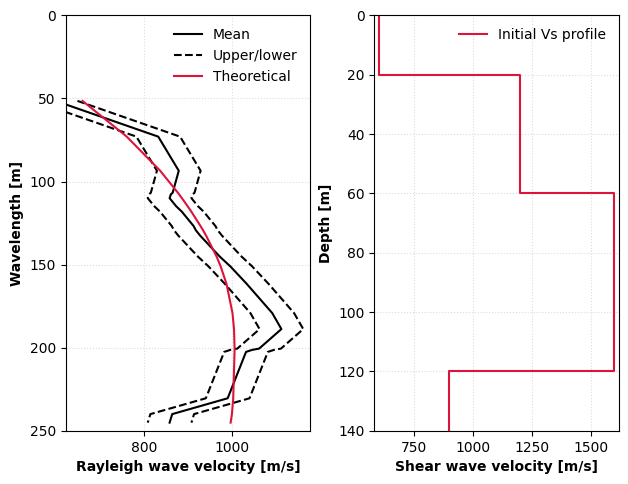

In [6]:
# Initialize the inversion routine. The inversion is conducted using 
# Monte Carlo sampling as described in Olafsdottir et al. (2020).

# Range for testing phase velocity
c_min = 200; c_max = 2500; c_step = 0.1; delta_c = 3
c_test = {'min' : c_min, 
          'max' : c_max,
          'step' : c_step,
          'delta_c' : delta_c}

# Initial model parameters
initial = {'n' : n,
           'n_unsat' : n_unsat,
           'alpha' : Vp, # alpha unsat
           'nu_unsat' : 0.18,
           'alpha_sat' : 4000, 
           'beta' : Vs,
           'rho' : rho,
           'h' : h,
           'reversals' : 0}

# Inversion algorithm settings. See further in Olafsdottir et al. (2020).
settings = {'run' : 20,
            'bs' : 5,
            'bh' : 10,
            'N_max' : 1000}        

# View the initial shear wave velocity profile.
# Compute the associated dispersion curve and show relative to the experimental
# data. The misfit value is printed to the screen.
max_depth = 140
inv_TestSite.view_initial(initial, max_depth, c_test, col='crimson', DC_yaxis='linear', 
                 fig=None, ax=None, figwidth=16, figheight=12, return_ct=False)

# Print message to user
print('The initial estimate of the Vs profile and the corresponding theoretical DC have been plotted.')

In [7]:
# Start the inversion analysis (optimization) process.
print('Inversion initiated.')
inv_TestSite.mc_inversion(c_test, initial, settings)



Inversion initiated.
Run no. 1/20 started.


KeyboardInterrupt: 

In [ ]:
# Plot sampled Vs profiles and associated dispersion curves
inv_TestSite.plot_sampled(max_depth, runs='all', figwidth=16, figheight=12, col_map='viridis', 
                  colorbar=True, DC_yaxis='linear', return_axes=False, show_exp_dc=True)

# Print message to user
print('All runs completed.')
print('The sampled Vs profiles and the corresponding theoretical DCs have been plotted.')

In [8]:

# Pickle the inversion object
file = 'AK_inversion'
inv_TestSite.save_to_pickle(file)

# Print message to user
print('The InvertDC object has been saved to disk as ' + file + '.p using pickle.')


The InvertDC object has been saved to disk as AK_inversion.p using pickle.


IndexError: list index out of range

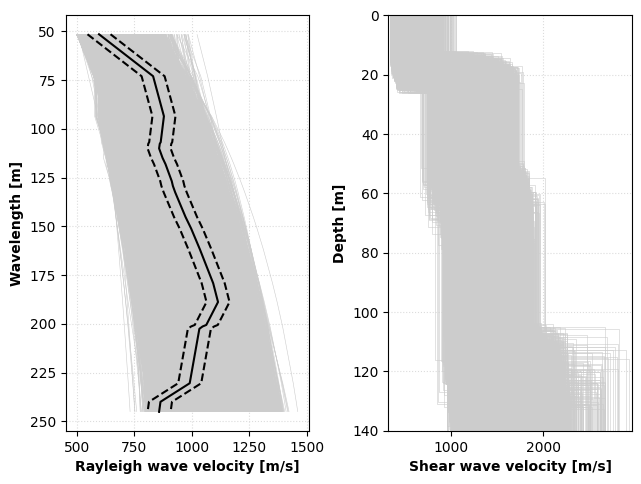

In [27]:
# Post-processing 
#
# Plot sampled Vs profiles whose associated dispersion curves fall within the
# boundaries defined by c_low and c_up at all wavelengths
inv_TestSite.plot_within_boundaries(max_depth, show_all=True, runs='all', figwidth=16, figheight=12, 
                           col_map='viridis', colorbar=True, DC_yaxis='linear', return_axes=False)

# Print message to user
print('The set of accepted Vs profiles and the corresponding theoretical DCs have been plotted.')


The median of accepted Vs profiles has been computed.
The median profile and the corresponding theoretical DC have been plotted.
The 10 lowest-misfit Vs profiles have been identified.
The set of lowest-misfit profiles and the corresponding theoretical DCs have been plotted
Median Vs profile, z and Vsz values
[5, 10, 20, 30]
[149.57, 162.59, 176.68, 181.93]
Lowest-misfit Vs profile, z and Vsz values
[5, 10, 20, 30]
[149.71, 163.53, 178.65, 185.53]


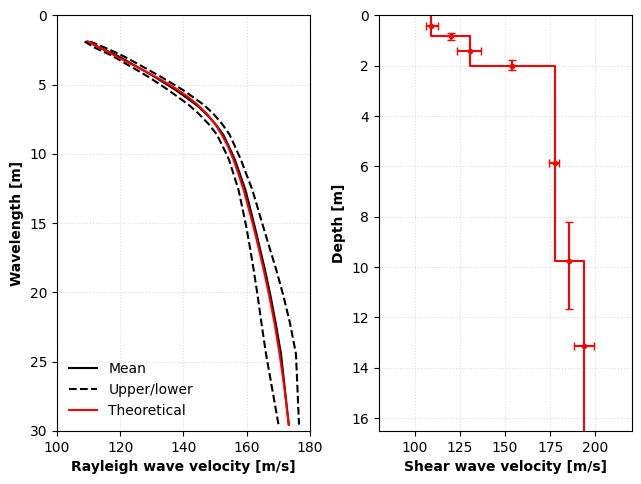

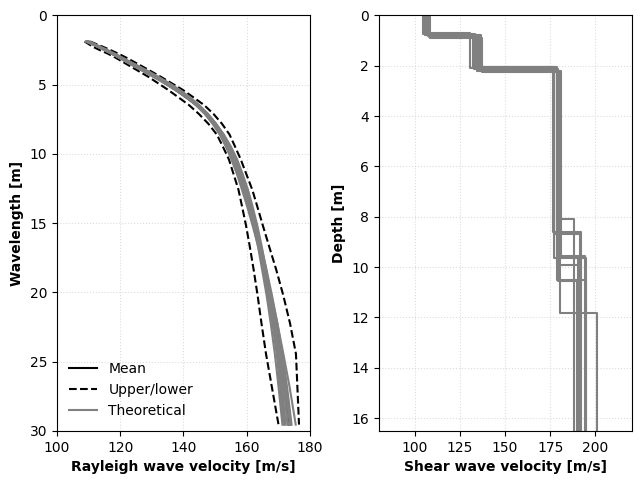

In [10]:

# Post-processing 
#
# Compute and plot the median shear wave velocity profile (defined in terms of
# shear wave velocity and depth of layer interfaces) and the 90-th percentiles 
# of each parameter. The associated theoretical dispersion curve is also 
# computed and shown relative to the experimetnal data. 
# The mean shear wave velocity profile can be obtained in a comparable way 
# using the inv_TestSite.mean_profile method. (See further in the documentation 
# of inversion.py.)

percentiles = [10,90]
TestSite_median_profile = inv_TestSite.median_profile(q=percentiles, dataset='selected')
fig, ax = inv_TestSite.plot_profile(TestSite_median_profile, max_depth, c_test, initial, 
                                    col='red', up_low=True, fig=None, ax=None, 
                                    return_axes=True, return_ct=False)

# Print message to user
print('The median of accepted Vs profiles has been computed.')
print('The median profile and the corresponding theoretical DC have been plotted.')


# Post-processing 
#
# Get and plot the 'no_profiles' shear wave velocity profiles (here 10) that show the lowest value 
# of the dispersion misfit function and whose associated dispersion curves 
# fall within the boundaries specified for the experimental disperion curve. 

lowest_misfit_profiles = {}
no_profiles = 10
# Ensure that at least no_profiles fall within the experimental DC boundaries
no_profiles_checked = min(no_profiles, len(inv_TestSite.selected['beta']))
for no in range(-1*no_profiles_checked,0):
    profile_dict = {'beta': inv_TestSite.selected['beta'][no], 'z': inv_TestSite.selected['z'][no]}
    if no == -1*no_profiles_checked:
        fig, ax = inv_TestSite.plot_profile(profile_dict, max_depth, c_test, initial, col='gray', 
                              up_low=False, DC_yaxis='linear', fig=None, ax=None, return_axes=True, show_legend=True)
    else:
        inv_TestSite.plot_profile(profile_dict, max_depth, c_test, initial, col='gray', 
                              up_low=False, DC_yaxis='linear', fig=fig, ax=ax, show_legend=False)
    lowest_misfit_profiles[no] = profile_dict

# Print message to user
print('The ' + str(no_profiles) + ' lowest-misfit Vs profiles have been identified.')
print('The set of lowest-misfit profiles and the corresponding theoretical DCs have been plotted')


# Post-processing 
#
# Compute the average shear wave velocity (Vsz) for the top most z=5 m, z=10 m, z=20 m and z=30 m
# using (i) the median Vs profile and (ii) the lowest-misfit Vs profile.

depth = [5, 10, 20, 30]
layer_parameter = 'z'

# Median Vs profile
Vsz_median = inv_TestSite.compute_vsz(depth, TestSite_median_profile['beta'], 
                                      TestSite_median_profile['z'], layer_parameter)
print('Median Vs profile, z and Vsz values')
print(Vsz_median[0]) # Depths (z)
print([round(val, 2) for val in Vsz_median[1]]) # Computed Vsz values

# Lowest-misfit Vs profile
Vsz_lowest_misfit = inv_TestSite.compute_vsz(depth, inv_TestSite.selected['beta'][-1], 
                                             inv_TestSite.selected['z'][-1], layer_parameter)
print('Lowest-misfit Vs profile, z and Vsz values')
print(Vsz_lowest_misfit[0]) # Depths (z)
print([round(val, 2) for val in Vsz_lowest_misfit[1]]) # Computed Vsz values

In [ ]:
# import numpy as np

# def moving_average(wavelengths, window=5):
#     kernel = np.ones(window) / window
#     return np.convolve(wavelengths, kernel, mode='same')

# wavelengths_smooth = moving_average(wavelengths, window=80)   # window must be odd for symmetry
 

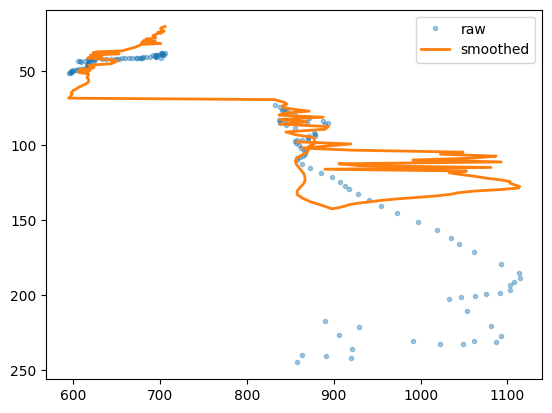

In [ ]:
# import matplotlib.pyplot as plt

# plt.plot(c_mean, wavelengths, '.',  alpha=0.4, label='raw')
# plt.plot(c_mean, wavelengths_smooth, '-', linewidth=2, label='smoothed')
# plt.gca().invert_yaxis() 
# plt.legend()

In [ ]:
# wavelengths_smooth

array([ 21.00790909,  24.58836364,  28.17336364,  31.75863636,
        35.35363636,  38.964     ,  39.11018182,  39.28372727,
        39.47472727,  39.66809091,  39.86563636,  40.03845455,
        40.18745455,  40.341     ,  40.49681818,  40.65045455,
        40.79836364,  40.95872727,  41.09409091,  41.21518182,
        41.31581818,  41.38881818,  41.45790909,  41.52690909,
        41.58836364,  41.64836364,  41.70509091,  41.75518182,
        41.79036364,  41.82381818,  41.84518182,  41.86790909,
        41.89672727,  41.92581818,  41.97545455,  42.08763636,
        42.22590909,  42.36845455,  42.50818182,  42.65590909,
        42.80309091,  42.95063636,  43.14427273,  43.41318182,
        43.71763636,  44.02445455,  44.29818182,  44.56936364,
        44.87072727,  45.21136364,  45.57427273,  45.96654545,
        46.38527273,  46.77572727,  47.10436364,  47.40972727,
        47.705     ,  47.99063636,  48.27336364,  48.532     ,
        48.78118182,  49.02790909,  49.28754545,  49.55

In [ ]:
# wavelengths

array([ 38.162,  38.207,  38.306,  38.516,  38.785,  39.111,  39.385,
        39.435,  39.438,  39.545,  39.714,  39.77 ,  40.116,  40.407,
        40.643,  40.958,  41.012,  41.024,  41.124,  41.152,  41.235,
        41.341,  41.534,  41.605,  41.739,  41.75 ,  41.761,  41.772,
        41.783,  41.8  ,  41.812,  41.859,  41.892,  41.921,  41.973,
        41.974,  42.   ,  42.078,  42.092,  42.329,  43.034,  43.333,
        43.427,  43.429,  43.546,  43.592,  43.597,  44.13 ,  45.036,
        45.441,  45.704,  46.045,  46.316,  46.742,  47.176,  47.538,
        47.907,  48.203,  48.425,  48.651,  48.8  ,  48.952,  49.187,
        49.426,  49.587,  49.917,  50.252,  50.763,  51.111,  51.466,
        51.739,  72.982,  74.159,  75.357,  76.216,  76.455,  77.248,
        79.074,  81.495,  82.745,  82.871,  83.774,  83.8  ,  84.369,
        84.646,  85.143,  85.577,  86.224,  88.247,  91.354,  92.421,
        93.511,  93.763,  94.674,  95.604,  96.   ,  96.404,  97.273,
        98.506, 100.

In [ ]:
# from scipy.ndimage import gaussian_filter1d
# y_smooth = gaussian_filter1d(wavelengths, sigma=2)   # sigma in samples


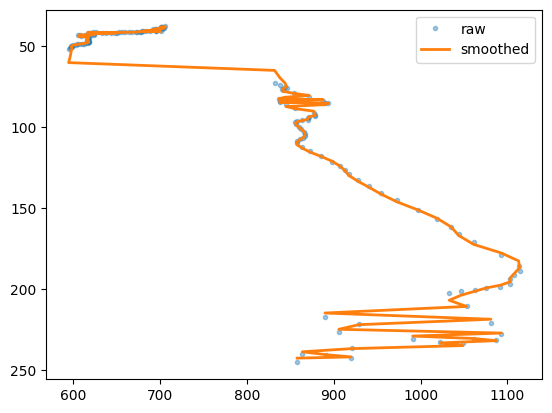

In [ ]:
# plt.plot(c_mean, wavelengths, '.',  alpha=0.4, label='raw')
# plt.plot(c_mean, y_smooth, '-', linewidth=2, label='smoothed')
# plt.gca().invert_yaxis() 
# plt.legend()